**# Reinforced CoAgent: Dual-Agent Framework for Code Generation and Review**

In [ ]:
!pip install --upgrade torch torchvision torchaudio transformers accelerate pip setuptools wheel

In [ ]:
pip install pylint flake8 mypy autopep8

  Using cached pylint-3.3.2-py3-none-any.whl.metadata (12 kB)
  Using cached flake8-7.1.1-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached mypy-1.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached autopep8-2.3.1-py2.py3-none-any.whl.metadata (16 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached astroid-3.3.5-py3-none-any.whl.metadata (4.5 kB)
  Using cached isort-5.13.2-py3-none-any.whl.metadata (12 kB)
  Using cached mccabe-0.7.0-py2.py3-none-any.whl.metadata (5.0 kB)
  Using cached tomlkit-0.13.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached pycodestyle-2.12.1-py2.py3-none-any.whl.metadata (4.5 kB)
  Using cached pyflakes-3.2.0-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached mypy_extensions-1.0.0-py3-none-any.whl.metadata (1.1 kB)
Using cached pylint-3.3.2-py3-none-any.whl (521 kB)
Using cached flake8-7.1.1-py2.py3-none-any.whl (57 kB)
Using cached mypy-1.13.0-cp310-cp310-m

In [ ]:
import random
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW
import subprocess
import tempfile
import autopep8
import ast
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono")
model = AutoModelForCausalLM.from_pretrained("Salesforce/codegen-350M-mono").to(device)

# tokenizer = AutoTokenizer.from_pretrained("migtissera/Trinity-2-Codestral-22B")
# model = AutoModelForCausalLM.from_pretrained("migtissera/Trinity-2-Codestral-22B").to(device)

# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B").to(device)
tokenizer.pad_token = tokenizer.eos_token

def generate_text(prompt, max_new_tokens=150, temperature=0.8, top_p=0.9, top_k=50):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

class EncoderAgent:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt_encoder = """
        Encoder Agent:
        You are a programmer specializing in data science.
        Your task is to write a script to analyze the given sales data.
        Ensure the code follows **PEP 8 standards** for readability and formatting.
        Please provide only the Python code, without any theoretical explanation.
        """

    def generate_code(self,task_description):
      prompt = f"{self.prompt_encoder}\nTask: {task_description}\n\nPython Code:\n"
      generated_text = generate_text(prompt)

      # Extract only the code generated after "Python Code:\n"
      if "Python Code:" in generated_text:
          code = generated_text.split("Python Code:\n", 1)[1]
          return code.strip()  # Remove extra spaces around
      else:
          return "No code generated."


class ReviewerAgent:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt_reviewer = """
        Reviewer Agent:
        You are a code reviewer specializing in data science.
        You must identify errors (especially syntax errors) and suggest some improvements.
        Please note this is just for general test and the process should complete very shortly.
        """

    def review_code(self,code):
      prompt = f"{self.prompt_reviewer}\n\n{code}\n\nReview:\n"
      full_response = generate_text(prompt)  # Generates full text

      # Extract only the review text
      marker = "Review:"
      start_idx = full_response.find(marker)
      if start_idx != -1:
          return full_response[start_idx + len(marker):].strip()
      else:
          return "Review not found"

    def code_metrics(self, code):

        lines_of_code = len(code.split('\n'))

        function_defs = [line for line in code.split('\n') if 'def ' in line]
        num_functions = len(function_defs)

        # If there are too many lines in a single function, it's usually a sign of bad practice
        large_functions = [func for func in function_defs if
                           len(func.split()) > 20]

        # Check for unused imports
        unused_imports = [line for line in code.split('\n') if line.startswith('import') and 'as ' not in line]

        # Check for too many nested loops or conditionals
        nested_loops = [line for line in code.split('\n') if 'for ' in line or 'if ' in line]
        num_nested_loops = len(nested_loops)

        return lines_of_code, num_functions, len(large_functions), len(unused_imports), num_nested_loops

    # Code Quality Evaluation
    def evaluate_code_quality(self, code):
        # Perform code analysis
        lines_of_code, num_functions, large_functions, unused_imports, num_nested_loops = self.code_metrics(code)

        feedback = ""

        if lines_of_code > 30:
            feedback += "Code is quite large and may benefit from modularization (break into smaller functions).\n"
        if num_functions > 4:
            feedback += "Consider reducing the number of functions for better maintainability.\n"
        if large_functions > 2:
            feedback += "Some functions are too long. Consider breaking them down into smaller, more manageable functions.\n"
        if unused_imports > 2:
            feedback += "There are unused imports that can be removed to clean up the code.\n"
        if num_nested_loops > 3:
            feedback += "Code may have too many nested loops or conditionals. Consider simplifying the logic.\n"

        # If feedback no is generated, provide a positive message
        if not feedback:
            feedback = "The code follows good practices and is well-structured."

        return feedback

def validate_syntax(code):
    try:
        ast.parse(code)
        return True
    except SyntaxError as e:
        print(f"Syntax Error: {e}")
        return False

def fix_syntax_with_autopep8(code):
    try:
        fixed_code = autopep8.fix_code(code)
        return fixed_code
    except Exception as e:
        print(f"Error fixing code: {e}")
        return code  # Returns original code if failure

def analyze_with_pylint(code):
    # Check syntax before running pylint
    if not validate_syntax(code):
        print("Invalid syntax. Skipping Pylint analysis.")
        code = fix_syntax_with_autopep8(code)
        if not validate_syntax(code):  # Check again after correction
            print("Syntax still invalid after attempted fix.")
            return 0.0

    # Continue with the process if the code is valid
    with tempfile.NamedTemporaryFile(suffix=".py", delete=True) as temp_file:
        temp_file.write(code.encode('utf-8'))
        temp_file.flush()

        process = subprocess.Popen(
            ['pylint', '--disable=C,R', '--output-format=text', temp_file.name],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE
        )
        stdout, stderr = process.communicate()

        pylint_output = stdout.decode('utf-8').strip()

        score_line = [line for line in pylint_output.split("\n") if "Your code has been rated at" in line]
        if score_line:
          score = float(score_line[0].split("/")[0].split()[-1])
          if score == 0.0:
            score += 1
        else:
          score = 0.0

        return score

def analyze_with_flake8(code):
    # Save the code to a temporary file
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)

    # Run Flake8 on the temporary file
    result = subprocess.run(["flake8", "temp_code.py"], capture_output=True, text=True)

    # Capture only error codes using regex
    error_codes = re.findall(r"\b[EWFR]\d{3}\b", result.stdout)
    error_codes = list(set(error_codes))

    # Returns the count of the number of errors
    return len(error_codes)

def analyze_with_mypy(code: str) -> int:
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)
    result = subprocess.run(["mypy","--strict", "temp_code.py"], capture_output=True, text=True)
    feedback_lines = result.stdout.strip().split("\n")

    # Penalties based on error type
    penalties = {
        "no-untyped-def": 1,
        "incompatible type": 1,
        "callable": 1,
        "invalid syntax": 1
    }

    penalty_score = 0
    for line in feedback_lines:
        for issue, weight in penalties.items():
            if issue in line.lower():
                penalty_score += weight

    return penalty_score

def calculate_reward(code,review,review_feedback):
    pylint_score = analyze_with_pylint(code)
    flake8_violation = analyze_with_flake8(code)
    mypy_violation = analyze_with_mypy(code)

    reward = 0
    if "good" in review.lower():
        reward += 1

    reward += pylint_score / 5
    reward -= flake8_violation
    reward -= mypy_violation
    penalty = [1 for i in ["too long","too many", "maintainability", "unused","modularization"] if i in review_feedback]
    reward -= sum(penalty)
    benefit = [1 for i in ["def","import", "return","if","for"] if i in code]
    reward += sum(benefit)

    return reward,pylint_score,flake8_violation,mypy_violation

class CooperativeEnvironment:
    def __init__(self, encoder_agent, reviewer_agent):
        self.encoder_agent = encoder_agent
        self.reviewer_agent = reviewer_agent

    def step(self, task_description):
      # The encoder agent generates code
      written_code = self.encoder_agent.generate_code(task_description)
      print("\nGenerated Code:\n", written_code)

      # The reviewer agent provides feedback
      review = self.reviewer_agent.review_code(written_code)
      print("\nReview:\n", review)

      quality_feedback = self.reviewer_agent.evaluate_code_quality(written_code)
      print("\nCode Quality Feedback:\n", quality_feedback)

      reward,pylint_score,flake8_violation,mypy_violation = calculate_reward(written_code,review ,quality_feedback)

      # Convert reward to tensor for backpropagation
      reward_tensor = torch.tensor(reward, dtype=torch.float, device=device, requires_grad=True)

      return reward_tensor,pylint_score,flake8_violation,mypy_violation

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/797M [00:00<?, ?B/s]

Some weights of the model checkpoint at Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (e

In [ ]:
device

device(type='cuda')

In [ ]:
# Create agents
encoder_agent = EncoderAgent(model, tokenizer)
reviewer_agent = ReviewerAgent(model, tokenizer)

# Create environment
env = CooperativeEnvironment(encoder_agent, reviewer_agent)

# Fine-tuning loop (with gradient updates)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Initialize reward and loss history
reward_history = []
loss_history = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training loop
def train_agents(episodes=200):
    model.train()  # Set model to training mode
    pylint_scores = []
    flake8_violations = []
    mypy_violations = []

    for episode in range(episodes):
        print(f"\nEpisode {episode + 1}/{episodes}")

        # Select a random task description
        task_description = random.choice([
            "Write a function to clean and preprocess sales data.",
            "Write Python code to calculate the mean and variance of a dataset.",
            "Write a function to detect outliers in a dataset.",
            "Write a function to perform feature scaling on a dataset.",
            "Write a function to perform linear regression on a dataset."
        ])
        print("\nTask Description:", task_description)

        # Perform an environment step
        reward_tensor,pylint_score,flake8_violation,mypy_violation = env.step(task_description)
        reward_value = reward_tensor.item()

        # Track reward
        reward_history.append(reward_value)

        # Analyze code quality with Pylint, Flake8 and Mypy
        print(f"\nPylint Score: {pylint_score}\n")
        print(f"Flake8 Violations: {flake8_violation}\n")
        print(f"Mypy Violations: {mypy_violation}\n")
        print(f"\nReward: {reward_value}\n")

        # Log Pylint, Flake8 and Mypy metrics
        pylint_scores.append(pylint_score)
        flake8_violations.append(flake8_violation)
        mypy_violations.append(mypy_violation)

        # Fine-tune the model based on reward
        optimizer.zero_grad()
        loss = -reward_tensor  # Loss as negative reward
        loss_history.append(loss)
        loss.backward()
        optimizer.step()

        print(f"Loss: {-loss.item()}")

    # Display summary metrics
    print("\nTraining completed!")
    print(f"Average Pylint Score: {sum(pylint_scores) / len(pylint_scores):.2f}")
    print(f"Average Flake8 Violations: {sum(flake8_violations)/ len(flake8_violations):.2f}")
    print(f"Average Mypy Violations: {sum(mypy_violations) / len(mypy_violations):.2f}")

# Run training
train_agents(1000)

A saída de streaming foi truncada nas últimas 5000 linhas.

Flake8 Violations: 1

Mypy Violations: 0


Reward: 0.0

Loss: 0.0

Episode 895/1000

Task Description: Write a function to perform linear regression on a dataset.

Generated Code:
 - import numpy as np
    - from pandas import read_csv
   - Read the file in as dataframe
       - First, convert the column name to upper case
  - Convert the columns to lower case (or remove the first row).
 - Remove the header
     - Drop the rows with missing values
      - Replace the missing value with the mean value
         - Assign the new column to the value column
 * Return the data
"""


# def linear_regression(df):
def linearRegression():
	df = read("sales.csv")

Review:
 review = ["apple", "banana",  "orange",   "mango",    "strawberry"]
for i in range(len(review)):

	# print(i)
		# if i==0:

		df.loc[i, "Review"] = "apple"

Code Quality Feedback:
 The code follows good practices and is well-structured.
Syntax Error: invalid syntax (<u

In [ ]:
# Evaluate agents
def evaluate_agents(episodes=50):
    correct_code = 0
    incorrect_code = 0
    pylint_scores = []
    flake8_violations = []
    mypy_violations = []

    for episode in range(episodes):
        print(f"\nEpisode {episode + 1}/{episodes}")

        task_description = random.choice([
            "Write a function to clean and preprocess sales data.",
            "Write Python code to calculate the mean and variance of a dataset.",
            "Write a function to detect outliers in a dataset.",
            "Write a function to perform feature scaling on a dataset.",
            "Write a function to perform linear regression on a dataset."
        ])
        print("\nTask Description:", task_description)

        # Perform an environment step
        reward_tensor,pylint_score,flake8_violation,mypy_violation = env.step(task_description)
        reward_value = reward_tensor.item()

        # Output analysis results
        print(f"\nPylint Score: {pylint_score}\n")
        print(f"Flake8 Violations: {flake8_violation}\n")
        print(f"Mypy Violations: {mypy_violation}\n")
        print(f"\nReward: {reward_value}")

        # Log Pylint, Flake8 and Mypy metrics
        pylint_scores.append(pylint_score)
        flake8_violations.append(flake8_violation)
        mypy_violations.append(mypy_violation)

        # Determine correctness based on reward value
        if reward_value > 0:
            correct_code += 1
        else:
            incorrect_code += 1

    # Print summary metrics
    print(f"\nEvaluation completed: {correct_code} correct, {incorrect_code} incorrect")
    print(f"Average Pylint Score: {sum(pylint_scores) / len(pylint_scores):.2f}")
    print(f"Average Flake8 Violations: {sum(flake8_violations)/len(flake8_violations):.2f}")
    print(f"Average Mypy Violations: {sum(mypy_violations) / len(mypy_violations):.2f}")

# Run evaluation
evaluate_agents(200)

A saída de streaming foi truncada nas últimas 5000 linhas.
 - Import necessary libraries. 
    - pandas
      - Pandas is a library used to read, write and manipulate data in a structured, tabular manner. Pandase data is used for data analysis and modelling. Python is an elegant and modern data structure. The most powerful feature in Python comes the Pandata package. For data manipulation, you can write code to create and work with data, and then manipulate it. You can also create dataframes using pandapss and pandoc. It is also very simple and efficient. In addition, the data can be created using the pandapi library. This library is mostly used by other libraries and in this module we are using Pandapis to convert data into pandata objects. Please

Review:
 1. Review the code in the main.py file. What are the output from your code? What should you expect?
2. To add new code, follow the following steps: 

    a. Change the name of the file to something like:

        # Below is the ori

Reward Plot

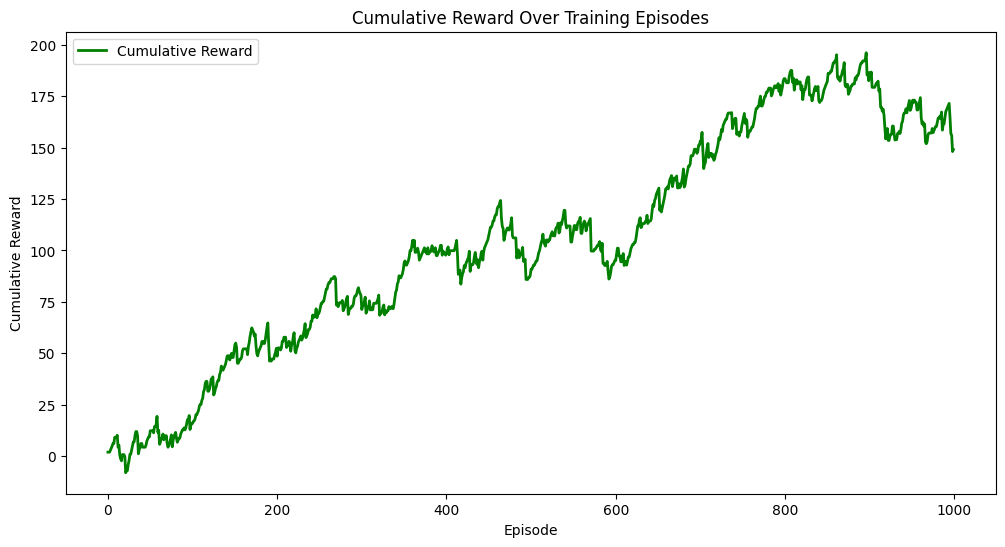

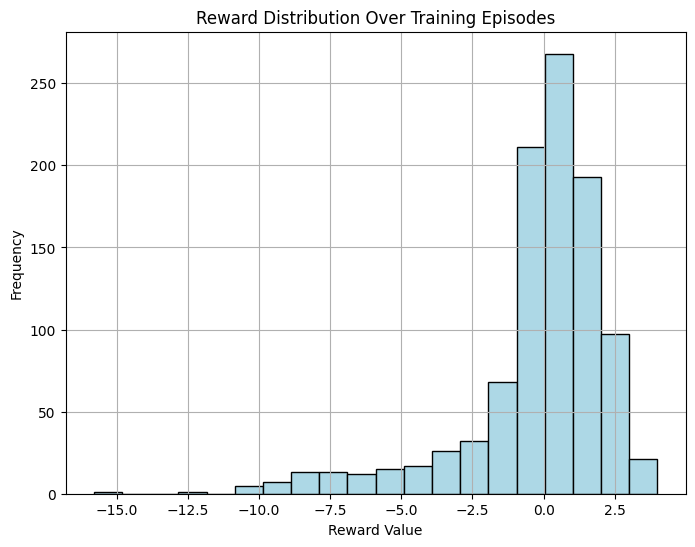

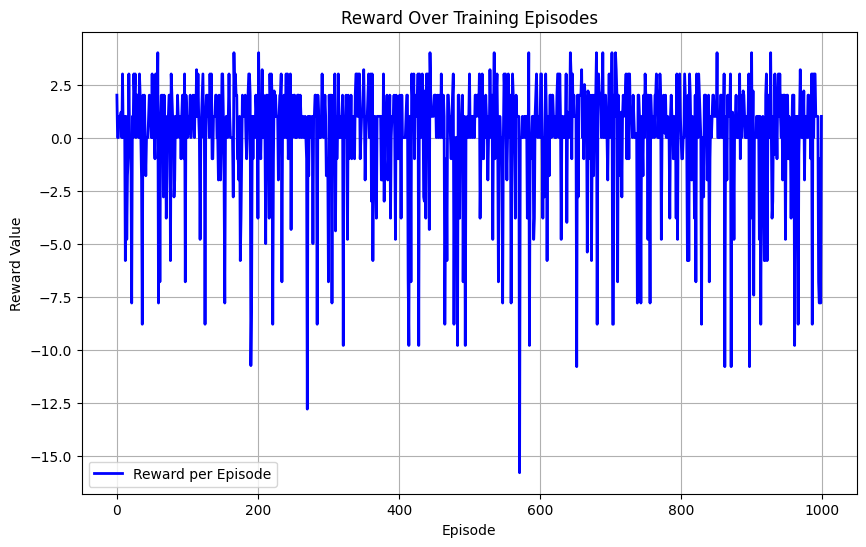

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Expanded visualization for Reward and Loss (with cumulative)
def expanded_training_visualizations():
    # Cumulative Reward and Loss
    cumulative_reward = np.cumsum(reward_history)
    #cumulative_loss = np.cumsum(loss_history)

    plt.figure(figsize=(12, 6))

    # Subplot for Cumulative Reward
    plt.plot(cumulative_reward, label="Cumulative Reward", color='green', lw=2)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward Over Training Episodes')
    plt.legend()

    plt.show()

# Call the function to see the expanded reward/loss visualization
expanded_training_visualizations()

# Histogram of Reward Distribution
def reward_distribution():
    plt.figure(figsize=(8, 6))
    plt.hist(reward_history, bins=20, edgecolor='black', color='lightblue')
    plt.title('Reward Distribution Over Training Episodes')
    plt.xlabel('Reward Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Call the function to see the reward distribution
reward_distribution()

# Line plot of Reward over Episodes
def reward_over_episodes():
    plt.figure(figsize=(10, 6))
    plt.plot(reward_history, label='Reward per Episode', color='blue', lw=2)
    plt.title('Reward Over Training Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize reward over episodes
reward_over_episodes()

# Line plot of Loss over Episodes
def loss_over_episodes():
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Loss per Episode', color='orange', lw=2)
    plt.title('Loss Over Training Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()


Boxplot of Reward

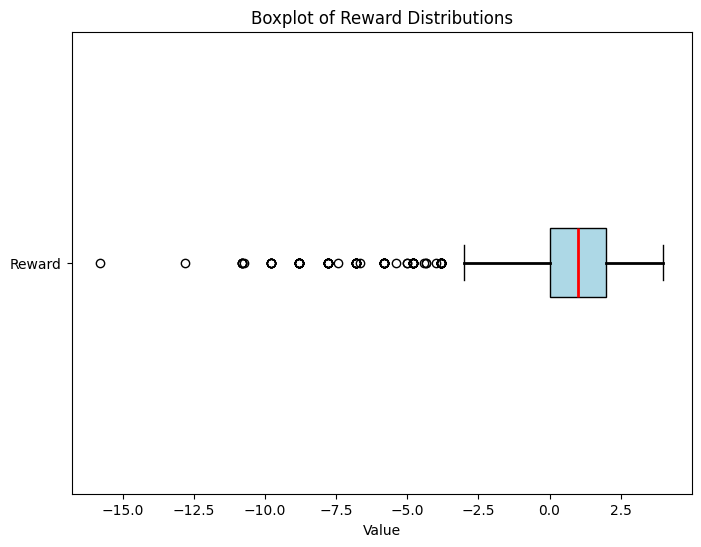

In [ ]:
def reward_boxplot():
    data = [reward_history]
    plt.figure(figsize=(8, 6))
    plt.boxplot(data, vert=False, patch_artist=True, labels=['Reward'],
                boxprops=dict(facecolor='lightblue', color='black'),
                whiskerprops=dict(color='black', linewidth=2),
                medianprops=dict(color='red', linewidth=2))
    plt.title('Boxplot of Reward Distributions')
    plt.xlabel('Value')
    plt.show()

# Call the function to see the boxplot
reward_boxplot()

Heatmap of Reward

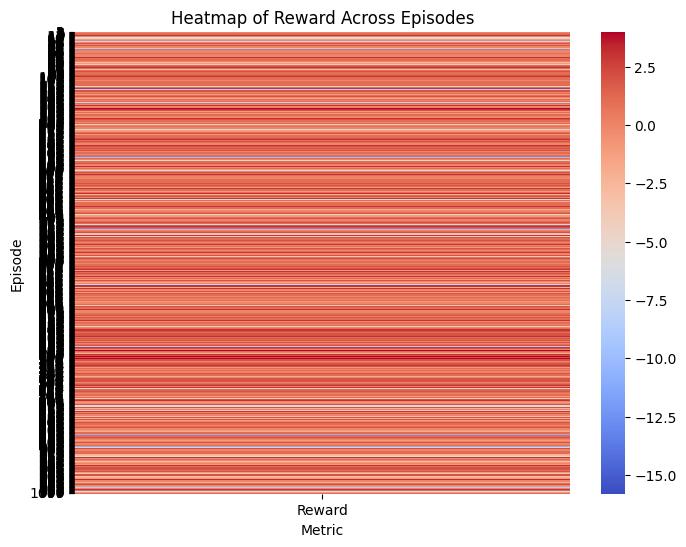

In [ ]:
def reward_heatmap():
    # Create a 2D array where each row is an episode and columns are reward and loss
    data = np.array([reward_history]).T

    plt.figure(figsize=(8, 6))
    sns.heatmap(data, cmap='coolwarm', annot=False, xticklabels=['Reward'], yticklabels=range(1, len(reward_history)+1))
    plt.title('Heatmap of Reward Across Episodes')
    plt.xlabel('Metric')
    plt.ylabel('Episode')
    plt.show()

# Call the function to see the heatmap
reward_heatmap()

Violin Plot for Reward

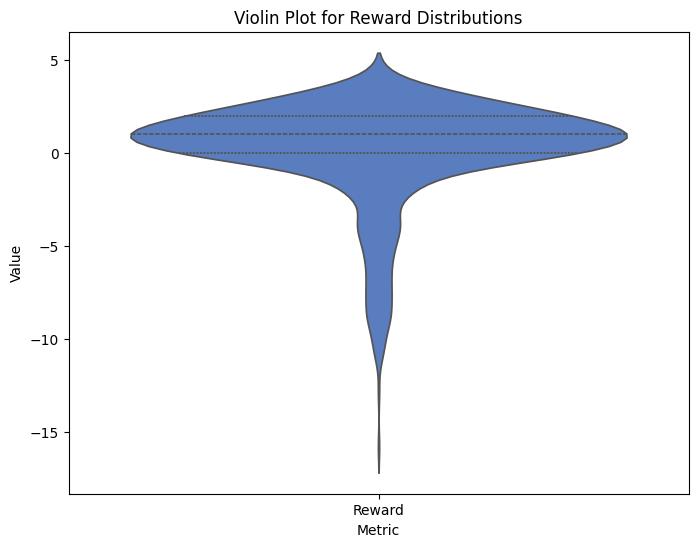

In [ ]:
def reward_violin_plot():
    # Create a DataFrame with named columns for Reward
    data = pd.DataFrame({
        'Reward': reward_history
    })

    # Plotting the violin plot
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=data, inner="quart", palette="muted")
    plt.title('Violin Plot for Reward Distributions')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.show()

# Call the function to visualize the distribution
reward_violin_plot()